In [2]:
# Kullanmak istediğimiz bir GPU varsa burada GPU id verebiliriz
# Colab' de çalışıyorsanız gerek yok
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import shutil
from sklearn.model_selection import train_test_split
import glob
import random
import os

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


import time
import datetime
import sys

from torch.autograd import Variable
import torch
import numpy as np
import itertools
from tqdm import tqdm_notebook as tqdm
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary
from torchvision.utils import save_image
import pandas as pd
from IPython.display import Image as ImageDisplay

Ön işleme Adımı

In [6]:
image_dir = './dataset/img_align_celeba/img_align_celeba'
attributes_file = './dataset/list_attr_celeba.csv'
output_dir = './dataset/preprocessed_dataset_celeba'
data = pd.read_csv(attributes_file)

In [7]:
df_blackHair = data.loc[data['Black_Hair' ] == 1 & (data['Male'] == -1)].sample(n=1000)
df_blondHair = data.loc[data['Blond_Hair'] == 1 & (data['Male'] == -1)].sample(n=1000)

In [8]:
domainA, domainB = [], []

for index, row in df_blackHair.iterrows():
    domainA.append(row['image_id'])

for index, row in df_blondHair.iterrows():
    domainB.append(row['image_id'])
    

Veri seti eğitim - test olarak bölünüyor

In [9]:
A_train, A_test = train_test_split(domainA, test_size=0.01, random_state=42)
B_train, B_test = train_test_split(domainB, test_size=0.01, random_state=42)

Eğitim ve test veri seti başka bir yere kaydediliyor

In [10]:
#train
N = min(len(A_train), len(B_train))
A_train = A_train[:N]
B_train = B_train[:N]
print(f'Images in A {len(A_train)} and B {len(B_train)}')

A_train_dir = os.path.join(output_dir, 'train/A')
B_train_dir = os.path.join(output_dir, 'train/B')

os.makedirs(A_train_dir, exist_ok=True)
os.makedirs(B_train_dir, exist_ok=True)

#orijinal lokasyondan yeni lokasyona kopyalıyoruz
for imageA, imageB in zip(A_train, B_train):
    shutil.copy(os.path.join(image_dir, imageA), os.path.join(A_train_dir, imageA))
    shutil.copy(os.path.join(image_dir, imageB), os.path.join(B_train_dir, imageB))
    
#test verisi de eşit olsun
N = min(len(A_test), len(B_test))
A_test = A_test[:N]
B_test = B_test[:N]
print(f'Images in A {len(A_test)} and B {len(B_test)}')

A_test_dir = os.path.join(output_dir, 'test/A')
B_test_dir = os.path.join(output_dir, 'test/B')

os.makedirs(A_test_dir, exist_ok=True)
os.makedirs(B_test_dir, exist_ok=True)

for imageA, imageB in zip(A_test, B_test):
    shutil.copy(os.path.join(image_dir, imageA), os.path.join(A_test_dir, imageA))
    shutil.copy(os.path.join(image_dir, imageB), os.path.join(B_test_dir, imageB))

Images in A 990 and B 990
Images in A 10 and B 10


Dataset sınıfımız

In [11]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        #gelen transform fonksiyonu kullanılıyor
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        # eğitim yapılırken her veri alışında bu fonksiyona giriliyor ve verie ön işlemden geçiriliyor
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            #veriler eşli olmadığından dolayı rastgele bir imge seçiliyor
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

Generator blokları ve Generator yapay sinir ağı tasarımı

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


Discriminator Yapay Sinir ağı tasarımı

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

Ek fonksiyonlar

In [14]:
def tensor2image(tensor):
    #görselleştirme amacı ile gpu ya atılmış tensor verisi işlemci üzerinde imgeye dönüştürlür.
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

class ReplayBuffer():
    # Kayıp hesabı yapılırken Buffer a veri atıp çıkartıyoruz
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    # Learning rate decay ayarları burada yapılıyor
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    # Yapay sinir ağının ağırlıklarının uniform bir dağılımda ilklendirilmesi için bu fonksiyon kullanılıyor.
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

Eğitim parametreleri

In [15]:
epoch=0
n_epochs=50
batchSize=1
dataroot='./dataset/preprocessed_dataset_celeba/' 
lr=0.0002
decay_epoch=3
size=256
input_nc=3 
output_nc = 3
cuda =True
n_cpu=8


Eğitim başlangıcı

In [16]:

if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, size, size)
input_B = Tensor(batchSize, output_nc, size, size)
target_real = Variable(Tensor(batchSize,1).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchSize,1).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_ = [ transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=batchSize, shuffle=True, num_workers=n_cpu)


G_loss = []
G_identity_loss = []
G_gan_loss = []
G_cycle_loss = []
D_loss = []


AssertionError: Torch not compiled with CUDA enabled

In [57]:
###### Training ######
pbar = tqdm(range(epoch, n_epochs))
for epoch in pbar:
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        pbar.set_postfix({'loss_G': loss_G.item(),
                    'loss_G_cycle': (loss_cycle_ABA .item()+ loss_cycle_BAB.item()), 'loss_D': (loss_D_A.item()+ loss_D_B.item())})
        G_loss.append(loss_G.item())
        G_identity_loss.append(loss_identity_A.item() + loss_identity_B.item())
        G_gan_loss.append(loss_GAN_A2B.item() + loss_GAN_B2A.item())
        G_cycle_loss.append(loss_cycle_ABA .item()+ loss_cycle_BAB.item())
        D_loss.append(loss_D_A.item()+ loss_D_B.item())
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(netD_B.state_dict(), 'output/netD_B.pth')
###################################

KeyboardInterrupt: 

/media/storage/files/furkan/py36_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


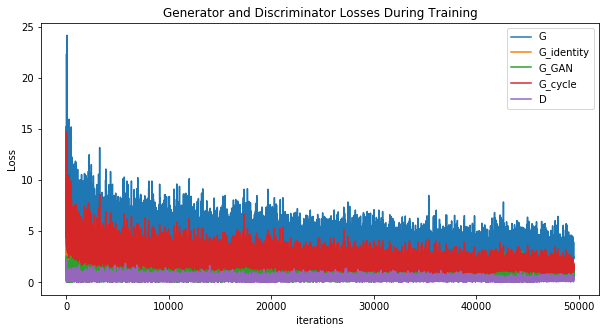

In [75]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_loss,label="G")
plt.plot(G_identity_loss,label="G_identity")
plt.plot(G_gan_loss, label="G_GAN")
plt.plot(G_cycle_loss, label="G_cycle")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

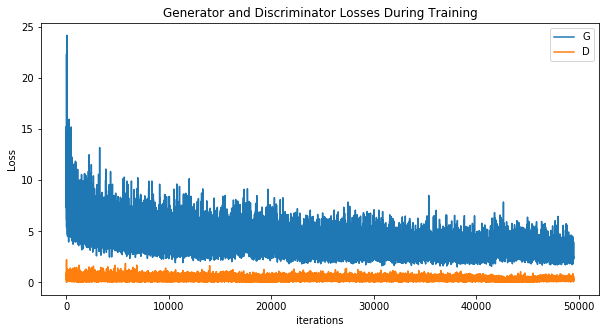

In [76]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

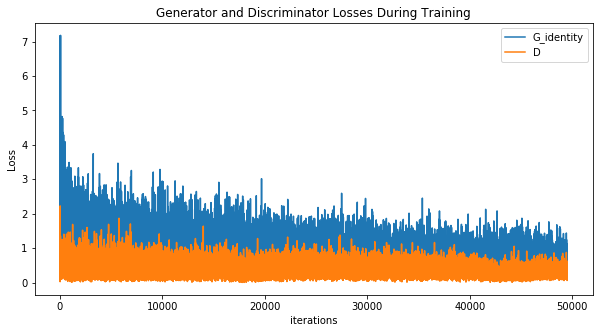

In [77]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_identity_loss,label="G_identity")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

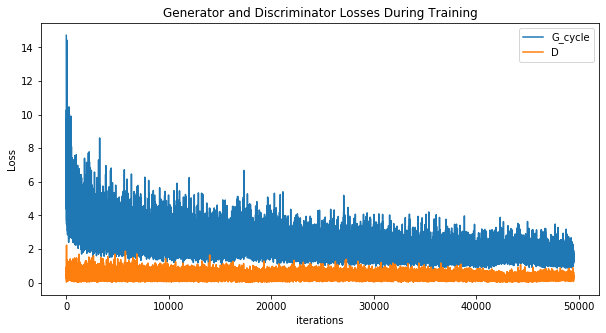

In [78]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_cycle_loss, label="G_cycle")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

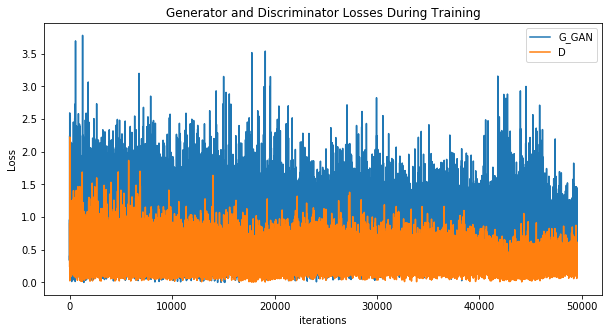

In [79]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_gan_loss, label="G_GAN")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Test aşaması

In [35]:
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
# Load state dicts
netG_A2B.load_state_dict(torch.load('./output/netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load('./output/netG_B2A.pth'))

<All keys matched successfully>

In [40]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, 313, 313)
input_B = Tensor(batchSize, output_nc, 313, 313)

transforms_ = [transforms.Resize((313,313), Image.BICUBIC), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, mode='test'), 
                        batch_size=batchSize, shuffle=False, num_workers=n_cpu)
###################################


save_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(218,178)),
    transforms.ToTensor()
])


###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    print(batch['A'].shape)
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    fake_A = fake_A.detach().cpu()
    fake_A = [save_transforms(x_) for x_ in fake_A]
    fake_B = fake_B.detach().cpu()
    fake_B = [save_transforms(x_) for x_ in fake_B]
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')
###################################

torch.Size([1, 3, 313, 313])
Generated images 0001 of 0010torch.Size([1, 3, 313, 313])
Generated images 0002 of 0010torch.Size([1, 3, 313, 313])
Generated images 0003 of 0010torch.Size([1, 3, 313, 313])
Generated images 0004 of 0010torch.Size([1, 3, 313, 313])
Generated images 0005 of 0010torch.Size([1, 3, 313, 313])
Generated images 0006 of 0010torch.Size([1, 3, 313, 313])
Generated images 0007 of 0010torch.Size([1, 3, 313, 313])
Generated images 0008 of 0010torch.Size([1, 3, 313, 313])
Generated images 0009 of 0010torch.Size([1, 3, 313, 313])
Generated images 0010 of 0010


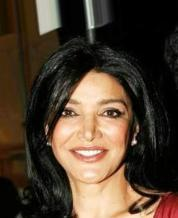

In [41]:
ImageDisplay('./dataset/preprocessed_dataset_celeba/test/A/198674.jpg')

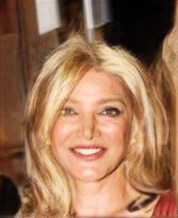

In [42]:
ImageDisplay('./output/B/0010.png')

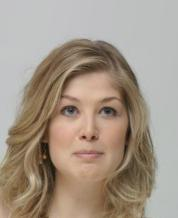

In [58]:
ImageDisplay('dataset/preprocessed_dataset_celeba/test/B/010868.jpg')

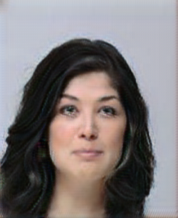

In [59]:
ImageDisplay('./output/A/0002.png')

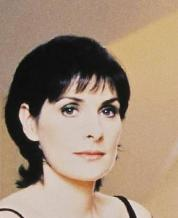

In [60]:
ImageDisplay('./dataset/preprocessed_dataset_celeba/test/A/053047.jpg')

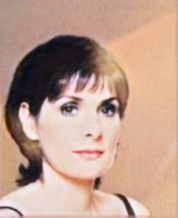

In [61]:
ImageDisplay('./output/B/0004.png')

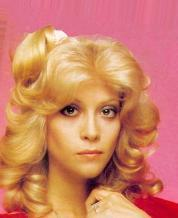

In [63]:
ImageDisplay('./dataset/preprocessed_dataset_celeba/test/B/158840.jpg')

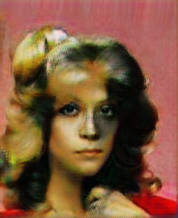

In [64]:
ImageDisplay('./output/A/0009.png')